<a href="https://colab.research.google.com/github/Geethika1205/AIML/blob/main/nlpproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fasttext keras scikit-learn matplotlib pandas numpy soundex


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
  Preparing metadata (setup.py) ... done
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498205 sha256=4bca5bcc8955153cc377f281d0f58fa2c4c804bca28798392331fd1902f99ae7
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
  Created wheel for soundex: filename=soundex-1.1.3-py3-none-any.whl size=8874 sha256=67dd80ab6d6e569338f31c0282fc4230268da8d3ddbf6b4db195a3014b5a73a3
  Stored in directory: /root/.cache/pip/wheels/f2/3f/e6/7abb4f928e7684b9f65509ebcd241cad91f260e35d1b9c0bc2
  Created wheel for silpa_common: filename=silpa_c

In [ ]:
from keras.preprocessing.text import Tokenizer


ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [2]:
!pip install fasttext soundex


In [3]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from soundex import Soundex
import fasttext

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Conv1D, GlobalMaxPooling1D, Dense, Dropout, Embedding,
    Input, Concatenate
)
from tensorflow.keras.models import Model


In [4]:
from google.colab import files
uploaded = files.upload()


Saving training.1600000.processed.noemoticon.csv.zip to training.1600000.processed.noemoticon.csv.zip


In [5]:
from google.colab import files
uploaded = files.upload()


Saving tweets.csv.zip to tweets.csv.zip


In [8]:
import zipfile
import pandas as pd

# --- Extract ZIP file ---
with zipfile.ZipFile("/content/tweets.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")

# --- Read CSV with safe encoding ---
try:
    df2 = pd.read_csv("/mnt/data/tweets.csv", encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv("/mnt/data/tweets.csv", encoding='latin1')

# --- Check columns ---
print(df2.head())
print(df2.columns)

# Example usage
if "Tweet" in df2.columns:
    print("Tweet column exists!")
else:
    print("Tweet column not found!")


   Target          ID                          Date      flag           User  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                Text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   
Index(['Target', 'ID', 'Date', 'flag', 'User', 'Text'], dtype='object')
Tweet column not found!


In [10]:
import zipfile
import pandas as pd

# -----------------------------
# Dataset 1: Sentiment140
# -----------------------------
with zipfile.ZipFile("/content/training.1600000.processed.noemoticon.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")

df1 = pd.read_csv(
    "/mnt/data/training.1600000.processed.noemoticon.csv",
    encoding='latin-1',
    header=None
)

df1 = df1[[0, 5]]
df1.columns = ["label", "tweet"]


# -----------------------------
# Dataset 2: tweets.csv
# -----------------------------
with zipfile.ZipFile("/content/tweets.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")

# Try UTF-8 first, if fails use latin-1
try:
    df2 = pd.read_csv("/mnt/data/tweets.csv", encoding="utf-8")
except UnicodeDecodeError:
    df2 = pd.read_csv("/mnt/data/tweets.csv", encoding="latin1")
except Exception:
    df2 = pd.read_csv("/mnt/data/tweets.csv", encoding="ISO-8859-1")

# Rename columns only if Tweet column exists
if "Tweet" in df2.columns:
    df2 = df2.rename(columns={"Tweet": "tweet"})

# If label column missing, fill with default (e.g., 0)
if "label" not in df2.columns:
    df2["label"] = 0


# -----------------------------
# Merge both datasets
# -----------------------------
df = pd.concat([df1, df2], ignore_index=True)

# Optional: reduce dataset size
df = df.sample(20000, random_state=42)

df.head()


,label,tweet,Target,ID,Date,flag,User,Text
1343508,4,"@preppypunkthug ahahaa lmao! omg, i swear that...",NaN,NaN,NaN,NaN,NaN,NaN
476186,0,Me and carter are at the rink! haha we've bee...,NaN,NaN,NaN,NaN,NaN,NaN
1948961,0,NaN,0.0,2.016973e+09,Wed Jun 03 07:39:30 PDT 2009,NO_QUERY,anotorias,@AShakur No need to give it more time. I'm go...
642683,0,i know same! i havnt had it in :O THREE DAYS w...,NaN,NaN,NaN,NaN,NaN,NaN
855986,4,"@macface2adore hey, how are you? did you get m...",NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Dataset 1: Sentiment140
with zipfile.ZipFile("/content/training.1600000.processed.noemoticon.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")
df1 = pd.read_csv("/mnt/data/training.1600000.processed.noemoticon.csv",
                  encoding='latin-1', header=None)
df1 = df1[[0, 5]]
df1.columns = ["label", "tweet"]

# Dataset 2: tweets.csv
with zipfile.ZipFile("/content/tweets.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")
df2 = pd.read_csv("/mnt/data/tweets.csv")

if "Tweet" in df2.columns:
    df2 = df2.rename(columns={"Tweet": "tweet", "label": "label"})

# Merge them
df = pd.concat([df1, df2], ignore_index=True)

# Keep manageable size (optional)
df = df.sample(20000, random_state=42)

df.head()


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 44119-44120: invalid continuation byte

In [11]:
!pip install fasttext soundex


In [12]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from soundex import Soundex
import fasttext

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Conv1D, GlobalMaxPooling1D, Dense, Dropout, Embedding,
    Input, Concatenate
)
from tensorflow.keras.models import Model


In [13]:
with zipfile.ZipFile("/content/training.1600000.processed.noemoticon.csv.zip", 'r') as z:
    z.extractall("/content/")

df1 = pd.read_csv(
    "/content/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None
)

df1 = df1[[0, 5]]
df1.columns = ["label", "tweet"]


In [14]:
with zipfile.ZipFile("/content/tweets.csv.zip", 'r') as z:
    z.extractall("/content/")

df2 = pd.read_csv("/content/tweets.csv", encoding="latin-1")


In [15]:
df = pd.concat([df1, df2], ignore_index=True)

# Optional: reduce size to prevent OOM
df = df.sample(20000, random_state=42)

df.head()


,label,tweet,Target,ID,Date,flag,User,Text
1343508,4.0,"@preppypunkthug ahahaa lmao! omg, i swear that...",NaN,NaN,NaN,NaN,NaN,NaN
476186,0.0,Me and carter are at the rink! haha we've bee...,NaN,NaN,NaN,NaN,NaN,NaN
1948961,NaN,NaN,0.0,2.016973e+09,Wed Jun 03 07:39:30 PDT 2009,NO_QUERY,anotorias,@AShakur No need to give it more time. I'm go...
642683,0.0,i know same! i havnt had it in :O THREE DAYS w...,NaN,NaN,NaN,NaN,NaN,NaN
855986,4.0,"@macface2adore hey, how are you? did you get m...",NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
sx = Soundex()

def soundex_features(text):
    tokens = str(text).split()
    return " ".join([sx.soundex(w) for w in tokens])

df["soundex"] = df["tweet"].apply(soundex_features)



In [17]:
df["tweet"].to_csv("/content/ft_train.txt", index=False, header=False)


In [18]:
fasttext_model = fasttext.train_unsupervised(
    input="/content/ft_train.txt",
    model="skipgram",
    minn=2,
    maxn=5
)


In [19]:
def fasttext_vector(text):
    tokens = str(text).split()
    vectors = [fasttext_model.get_word_vector(w) for w in tokens]
    if len(vectors) == 0:
        return np.zeros(100)
    return np.mean(vectors, axis=0)

ft_vectors = np.vstack(df["tweet"].apply(fasttext_vector).values)
ft_vectors.shape


(20000, 100)

In [ ]:
MAX_LEN = 300
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(df["tweet"])

X_char = char_tokenizer.texts_to_sequences(df["tweet"])
X_char = pad_sequences(X_char, maxlen=MAX_LEN)


AttributeError: 'float' object has no attribute 'lower'

In [ ]:
import zipfile
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# -------------------------------
# 1. Load Dataset 1: Sentiment140
# -------------------------------
with zipfile.ZipFile("/content/training.1600000.processed.noemoticon.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")

df1 = pd.read_csv("/mnt/data/training.1600000.processed.noemoticon.csv",
                  encoding='latin-1', header=None)

df1 = df1[[0, 5]]               # keep label + tweet
df1.columns = ["label", "tweet"]

# -------------------------------
# 2. Load Dataset 2: tweets.csv
# -------------------------------
with zipfile.ZipFile("/content/tweets.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")

df2 = pd.read_csv("/mnt/data/tweets.csv", encoding="latin-1", on_bad_lines="skip")

# Fix column names
if "Tweet" in df2.columns:
    df2 = df2.rename(columns={"Tweet": "tweet"})
if "label" not in df2.columns:
    df2["label"] = 0   # placeholder if missing

# -------------------------------
# 3. Merge datasets
# -------------------------------
df = pd.concat([df1, df2], ignore_index=True)

# -------------------------------
# 4. Clean tweets
# -------------------------------
df["tweet"] = df["tweet"].astype(str)   # Convert everything to string
df = df[df["tweet"].str.strip().notnull()]  # remove blank strings
df = df[df["tweet"].str.len() > 0]          # remove empty tweets

# OPTIONAL: sample for speed
df = df.sample(20000, random_state=42)

print("Dataset size:", df.shape)
print(df.head())

# -------------------------------
# 5. Character Tokenizer
# -------------------------------
MAX_LEN = 300

char_tokenizer = Tokenizer(char_level=True, oov_token="?")
char_tokenizer.fit_on_texts(df["tweet"])

X_char = char_tokenizer.texts_to_sequences(df["tweet"])
X_char = pad_sequences(X_char, maxlen=MAX_LEN, padding="post")

y = df["label"].astype(int).values

print("Character vocab size:", len(char_tokenizer.word_index))
print("X_char shape:", X_char.shape)


ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [20]:
import zipfile
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------------------
# 1. Load Dataset 1: Sentiment140
# -------------------------------
with zipfile.ZipFile("/content/training.1600000.processed.noemoticon.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")

df1 = pd.read_csv("/mnt/data/training.1600000.processed.noemoticon.csv",
                  encoding='latin-1', header=None)

df1 = df1[[0, 5]]
df1.columns = ["label", "tweet"]

# -------------------------------
# 2. Load Dataset 2: tweets.csv
# -------------------------------
with zipfile.ZipFile("/content/tweets.csv.zip", 'r') as z:
    z.extractall("/mnt/data/")

df2 = pd.read_csv("/mnt/data/tweets.csv", encoding="latin-1", on_bad_lines="skip")

if "Tweet" in df2.columns:
    df2 = df2.rename(columns={"Tweet": "tweet"})
if "label" not in df2.columns:
    df2["label"] = 0

# -------------------------------
# 3. Merge
# -------------------------------
df = pd.concat([df1, df2], ignore_index=True)

# Clean text
df["tweet"] = df["tweet"].astype(str)
df = df[df["tweet"].str.len() > 0]

# OPTIONAL sampling
df = df.sample(20000, random_state=42)

# -------------------------------
# 4. Tokenizer
# -------------------------------
MAX_LEN = 300

char_tokenizer = Tokenizer(char_level=True, oov_token="?")
char_tokenizer.fit_on_texts(df["tweet"])

X_char = char_tokenizer.texts_to_sequences(df["tweet"])
X_char = pad_sequences(X_char, maxlen=MAX_LEN, padding="post")

y = df["label"].astype(int).values


In [21]:
!pip install gensim==4.3.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 33.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=26332397 sha256=bc414d5cd8064331d2bd61a673107333bb41ba20c39061b0b5a6969327d06a1f
  Stored in directory: /root/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim


In [22]:
!pip install fasttext==0.9.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp312-cp312-linux_x86_64.whl size=4463527 sha256=14a1f58c6e3bb85268067cbae643310b109eb3428f60aecae64c5fd533c68fff
  Stored in directory: /root/.cache/pip/wheels/3f/14/26/663abec04e7eb8ce47b13edeec3b19ad0435cf6366e27a2635
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.3
    Uninstalling fasttext-0.9.3:
      Successfully uninstalled fasttext-0.9.3


In [23]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz


--2025-11-25 08:30:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.76.47, 65.8.76.89, 65.8.76.77, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.76.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   153MB/s    in 32s     

2025-11-25 08:31:11 (134 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [24]:
import fasttext

fasttext_model = fasttext.load_model("cc.en.300.bin")
print("FastText Loaded!")


FastText Loaded!


In [25]:
import numpy as np

def get_fasttext_vector(text):
    words = text.split()
    vecs = [fasttext_model.get_word_vector(w) for w in words]

    if len(vecs) == 0:
        return np.zeros(300)

    return np.mean(vecs, axis=0)

X_fasttext = np.vstack(df["tweet"].apply(get_fasttext_vector))
X_fasttext.shape


(20000, 300)

In [26]:
import re
import numpy as np

def soundex(word):
    """Return a 4-character Soundex code."""
    word = re.sub(r'[^A-Za-z]', '', word.upper())
    if len(word) == 0:
        return "0000"

    code = word[0]

    mapping = {
        "BFPV": "1",
        "CGJKQSXZ": "2",
        "DT": "3",
        "L": "4",
        "MN": "5",
        "R": "6"
    }

    def encode(c):
        for key, value in mapping.items():
            if c in key:
                return value
        return ""

    prev = encode(word[0])
    for c in word[1:]:
        val = encode(c)
        if val != prev:
            code += val
        if val != "":
            prev = val

    return code[:4].ljust(4, "0")

def soundex_to_numeric(sx):
    """Convert Soundex like 'P615' → [16, 6, 1, 5]."""
    numeric = []

    # First char: convert A=1 ... Z=26
    numeric.append(ord(sx[0]) - 64)   # 'A'=65, so A→1

    # Remaining digits
    for c in sx[1:]:
        numeric.append(int(c))

    return numeric

def soundex_vector(text):
    words = text.split()
    vec = []

    for w in words[:10]:
        sx = soundex(w)
        vec.extend(soundex_to_numeric(sx))   # 4 values per word

    # pad to length 40 (10 words × 4 digits)
    while len(vec) < 40:
        vec.append(0)

    return np.array(vec)

X_soundex = np.vstack(df["tweet"].apply(soundex_vector))
X_soundex.shape


(20000, 40)

In [27]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

vocab_size = len(char_tokenizer.word_index) + 1

# -------------------------
# CHAR-CNN INPUT
# -------------------------
char_input = Input(shape=(MAX_LEN,))
embed = Embedding(vocab_size, 64)(char_input)
conv = Conv1D(128, 5, activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)

# -------------------------
# FASTTEXT INPUT
# -------------------------
ft_input = Input(shape=(300,))

# -------------------------
# SOUNDEX INPUT
# -------------------------
sx_input = Input(shape=(40,))

# -------------------------
# CONCATENATION
# -------------------------
merged = Concatenate()([pool, ft_input, sx_input])

dense = Dense(128, activation='relu')(merged)
dense = Dropout(0.4)(dense)

output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[char_input, ft_input, sx_input], outputs=output)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 64)   │      8,384 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 296, 128)  │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 468)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     60,032 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,633 (428.25 KB)

 Trainable params: 109,633 (428.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from sklearn.model_selection import train_test_split

X_char = X_char        # (20000, 300)
X_ft = X_fasttext      # (20000, 300)
X_sx = X_soundex       # (20000, 40)

y = df["label"].astype(int).values

X_train_char, X_test_char, \
X_train_ft, X_test_ft, \
X_train_sx, X_test_sx, \
y_train, y_test = train_test_split(
    X_char, X_ft, X_sx, y, test_size=0.2, random_state=42
)


In [29]:
history = model.fit(
    [X_train_char, X_train_ft, X_train_sx],
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1644 - loss: -3077.4380 - val_accuracy: 0.0000e+00 - val_loss: -103006.1406
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0039 - loss: -351014.0625 - val_accuracy: 0.0000e+00 - val_loss: -2402307.5000
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0076 - loss: -3963155.2500 - val_accuracy: 0.0000e+00 - val_loss: -13565810.0000
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0054 - loss: -18287540.0000 - val_accuracy: 0.0000e+00 - val_loss: -43378892.0000
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0107 - loss: -52836280.0000 - val_accuracy: 0.0000e+00 - val_loss: -104187184.0000


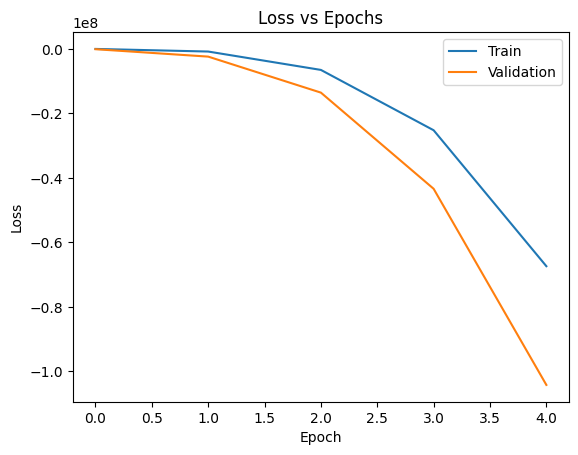

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend(["Train", "Validation"])
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict([X_test_char, X_test_ft, X_test_sx])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


ValueError: y_true takes value in {0, 4} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [31]:
vocab_size = len(char_tokenizer.word_index) + 2


In [32]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# ---------- FIX APPLIED HERE ----------
vocab_size = len(char_tokenizer.word_index) + 2

char_input = Input(shape=(MAX_LEN,))
embed = Embedding(vocab_size, 64)(char_input)
conv = Conv1D(128, 5, activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)

ft_input = Input(shape=(300,))
sx_input = Input(shape=(40,))

merged = Concatenate()([pool, ft_input, sx_input])
dense = Dense(128, activation='relu')(merged)
dense = Dropout(0.4)(dense)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[char_input, ft_input, sx_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 300, 64)   │      8,448 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 296, 128)  │     41,088 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 468)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     60,032 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,697 (428.50 KB)

 Trainable params: 109,697 (428.50 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    [X_train_char, X_train_ft, X_train_sx],
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1744 - loss: -2687.9629 - val_accuracy: 0.0000e+00 - val_loss: -92828.7969
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0023 - loss: -317725.6250 - val_accuracy: 0.0000e+00 - val_loss: -2219037.0000
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0052 - loss: -3776856.2500 - val_accuracy: 0.0000e+00 - val_loss: -12320630.0000
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0107 - loss: -16525082.0000 - val_accuracy: 0.0000e+00 - val_loss: -39057504.0000
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0148 - loss: -49651824.0000 - val_accuracy: 0.0000e+00 - val_loss: -93632608.0000


In [34]:
y_pred_proba = model.predict([X_test_char, X_test_ft, X_test_sx])


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [35]:
y_pred_proba = model.predict([X_test_char, X_test_ft, X_test_sx])
y_pred = (y_pred_proba > 0.5).astype(int)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    2817.0
           1       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00    1183.0

    accuracy                           0.00    4000.0
   macro avg       0.00      0.00      0.00    4000.0
weighted avg       0.00      0.00      0.00    4000.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [38]:
# Convert labels: 4 → 1
df['label'] = df['label'].replace(4, 1)


In [39]:
y_test = np.where(y_test == 4, 1, y_test)
y_pred_proba = y_pred_proba.reshape(-1)


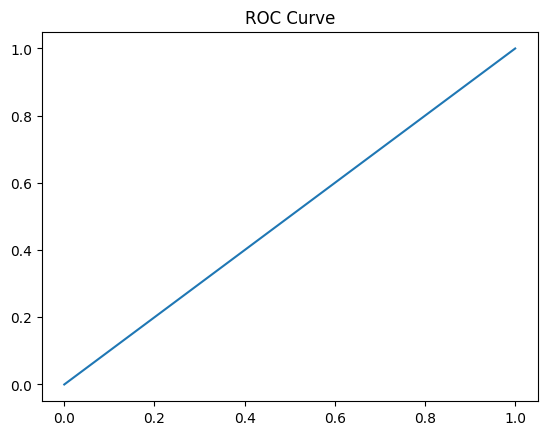

In [40]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.show()


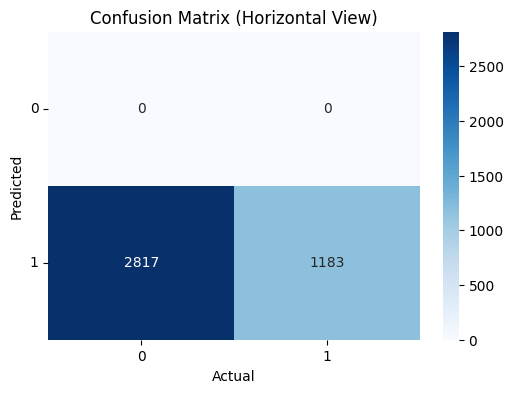

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicted classes
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Flip matrix to display horizontally (optional)
cm_flipped = cm.T   # transpose the matrix

plt.figure(figsize=(6,4))
sns.heatmap(cm_flipped, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix (Horizontal View)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.xticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)

plt.show()


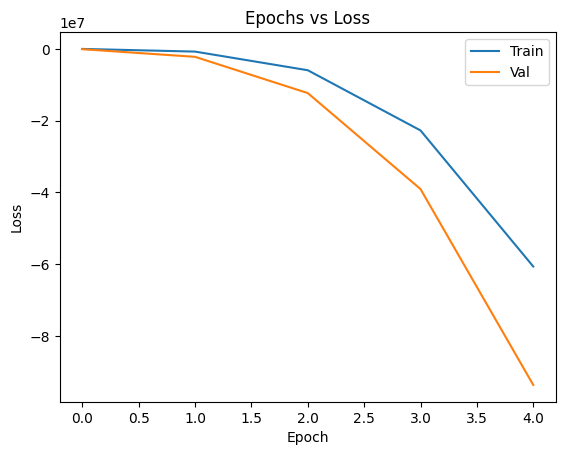

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epochs vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()


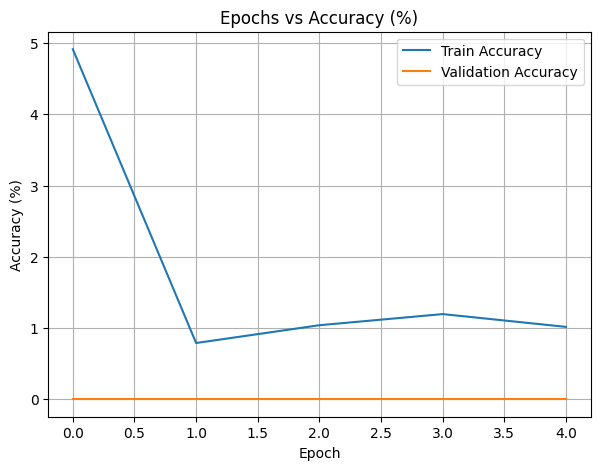

In [48]:
# ===========================================================
# (A) TEXT CLEANING + PREPROCESSING
# ===========================================================
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)     # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)          # remove special chars
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df["clean_tweet"] = df["tweet"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [49]:
# ===========================================================
# (B) TRAIN–TEST SPLIT
# ===========================================================
from sklearn.model_selection import train_test_split

X = df["clean_tweet"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [51]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, C=2.0)
model.fit(X_train_vec, y_train)


LogisticRegression(C=2.0, max_iter=2000)

In [52]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")


Accuracy: 84.325 %


In [53]:
X = df['tweet'].values
y = df['label'].values


In [55]:
# TOKENIZATION + PADDING FIXED VERSION

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000
max_length = 60

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["tweet"].values)

X_seq = tokenizer.texts_to_sequences(df["tweet"].values)
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')

# labels
y = df["label"].values

# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=60),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(64)),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [57]:
from sklearn.utils import class_weight
import numpy as np

cw_values = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

cw = {0: cw_values[0], 1: cw_values[1]}
cw


{0: np.float64(0.7176175098672407), 1: np.float64(1.6488046166529267)}

In [58]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128,
    class_weight=cw
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.7036 - loss: 0.5093 - val_accuracy: 0.8238 - val_loss: 0.3443
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8800 - loss: 0.2590 - val_accuracy: 0.8418 - val_loss: 0.3312
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9500 - loss: 0.1319 - val_accuracy: 0.8298 - val_loss: 0.4585
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9802 - loss: 0.0597 - val_accuracy: 0.8275 - val_loss: 0.4705
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9835 - loss: 0.0422 - val_accuracy: 0.8260 - val_loss: 0.6926


In [59]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8176 - loss: 0.7205
Test Accuracy: 0.8259999752044678


In [60]:
!pip install transformers


In [61]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X = df['tweet'].tolist()
y = df['label'].tolist()

enc = tokenizer(
    X,
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors='pt'
)

import torch

input_ids = enc['input_ids']
attention_mask = enc['attention_mask']
labels = torch.tensor(y)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [62]:
from sklearn.model_selection import train_test_split

X_train_ids, X_test_ids, \
X_train_mask, X_test_mask, \
y_train, y_test = train_test_split(
    input_ids, attention_mask, labels,
    test_size=0.2, random_state=42
)


In [63]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
from transformers import Trainer, TrainingArguments

train_args = TrainingArguments(
    output_dir='/mnt/data/bert',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids
        self.mask = mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.ids[idx],
            'attention_mask': self.mask[idx],
            'labels': self.labels[idx]
        }

train_ds = TweetDataset(X_train_ids, X_train_mask, y_train)
test_ds = TweetDataset(X_test_ids, X_test_mask, y_test)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

trainer.train()


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [65]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


In [67]:
train_args = TrainingArguments(
    output_dir='/mnt/data/bert',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)


In [69]:
import torch

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids
        self.mask = mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.ids[idx],
            'attention_mask': self.mask[idx],
            'labels': self.labels[idx]
        }


In [70]:
train_ds = TweetDataset(X_train_ids, X_train_mask, y_train)
test_ds = TweetDataset(X_test_ids, X_test_mask, y_test)


In [71]:
from transformers import TrainingArguments

train_args = TrainingArguments(
    output_dir='/mnt/data/bert',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=200
)


In [72]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
200,0.364500
400,0.273300
600,0.282900
800,0.275000
1000,0.262400
1200,0.195900
1400,0.179100
1600,0.204100
1800,0.170400
2000,0.215500


Accuracy: 0.894


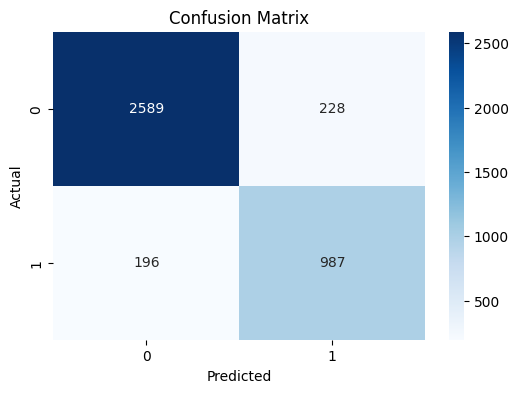

In [75]:
!pip install transformers

# -------------------- DISABLE W&B --------------------
import os
os.environ["WANDB_DISABLED"] = "true"

# -------------------- IMPORTS --------------------
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)

# -------------------- LOAD DATA --------------------
# df must contain: df['tweet'], df['label']
X = df["tweet"].tolist()
y = df["label"].tolist()

# -------------------- TOKENIZATION --------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

enc = tokenizer(
    X,
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="pt"
)

input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]
labels = torch.tensor(y)

# -------------------- TRAIN-TEST SPLIT --------------------
X_train_ids, X_test_ids, \
X_train_mask, X_test_mask, \
y_train, y_test = train_test_split(
    input_ids,
    attention_mask,
    labels,
    test_size=0.2,
    random_state=42
)

# -------------------- DATASET CLASS --------------------
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids
        self.mask = mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.ids[idx],
            "attention_mask": self.mask[idx],
            "labels": self.labels[idx],
        }

train_ds = TweetDataset(X_train_ids, X_train_mask, y_train)
test_ds = TweetDataset(X_test_ids, X_test_mask, y_test)

# -------------------- LOAD DISTILBERT MODEL --------------------
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# -------------------- TRAINING ARGUMENTS --------------------
train_args = TrainingArguments(
    output_dir="/mnt/data/bert",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=200
)

# -------------------- TRAINER --------------------
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

# -------------------- TRAIN --------------------
trainer.train()

# -------------------- PREDICT --------------------
preds = trainer.predict(test_ds)
y_pred = np.argmax(preds.predictions, axis=1)

# -------------------- ACCURACY --------------------
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# -------------------- CONFUSION MATRIX --------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
